<h2>PARTE EN SUCIO</h2>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import math
import random
from itertools import tee

In [2]:
def lectura(ruta_archivo: str):
    try:
        # Leer el contenido del archivo JSON
        with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
            datos_json = json.load(archivo)

        # Acceder a todas las entradas de "galactic_object"
        objetos_galacticos = datos_json.get("galactic_object", {})

        if objetos_galacticos:
            map = {}

            # Iterar a través de todas las entradas de "galactic_object"
            for id_objeto, objeto_galactico in objetos_galacticos.items():
                # Acceder e imprimir o utilizar propiedades específicas de cada "galactic_object"
                coordenada = objeto_galactico["coordinate"]
                nombre = objeto_galactico["name"]["key"]
                hyperlane = objeto_galactico.get("hyperlane",[])

                # Verificar si la longitud de hyperlane es mayor que 0, para eliminar vértices anormales
                if len(hyperlane) > 0:
                    # Guardar la información necesaria en el diccionario
                    map[int(id_objeto)] = [nombre, [(i["to"], i["length"]) for i in hyperlane], (coordenada["x"], coordenada["y"])]
            return map
        else:
            raise ValueError("La clave 'galactic_object' no existe en los datos JSON.") 
    
    except Exception as e:
        print(f"Error al leer o analizar el archivo JSON: {e}")



In [3]:
partida = lectura('../output/output1.json')

In [4]:
def test_lectura(diccionario):
    # Imprimir los 3 primeros elementos
    print('Mostrando los tres primeros sistemas de la galaxia:')
    for r in list(diccionario.items())[:3]:
        print(r[0], ": ", r[1])
    # Imprimir puntos suspensivos
    print("...")
    # Imprimir los 3 últimos elementos
    print('Mostrando los tres últimos sistemas de la galaxia:')
    for r in list(diccionario.items())[-3:]:
        print(r[0], ": ", r[1])

In [5]:
def genera_grafo(diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][1] for clave in diccionarioaux}
    grafo = nx.Graph()
    for r in diccionarioaux:
        if len(diccionarioaux[r])>0:
            grafo.add_edges_from((r, k[0]) for k in diccionarioaux[r])
    componentes_conexas = list(nx.connected_components(grafo))

    # Encontrar la componente conexa más grande
    tamanos_componentes = [len(componente) for componente in componentes_conexas]
    indice_componente_a_conservar = tamanos_componentes.index(max(tamanos_componentes))
    componente_a_conservar = list(componentes_conexas[indice_componente_a_conservar])

    # Crear un nuevo grafo con solo la componente conexa más grande
    G_componente_grande = grafo.subgraph(componente_a_conservar).copy()
    for r in diccionario.copy():
        if r not in G_componente_grande:
            diccionario.pop(r)
    return G_componente_grande

In [6]:
mapa = genera_grafo(partida)

In [7]:
def test_genera_grafo(diccionario) -> None:
    grafoaux = genera_grafo(diccionario)
    diccionarioaux = nx.to_dict_of_lists(grafoaux)
    print('Mostrando las conexiones de los tres primeros sistemas de la galaxia:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Mostrando las conexiones de los tres últimos sistemas:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[-3:]]

In [8]:
def adjudica_pesos(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][1] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    for origen in diccionarioaux:
        for destino, peso in diccionarioaux[origen]:
            grafoaux[origen][destino]['weight'] = peso
        
    return grafoaux

In [9]:
pesos_mapa = adjudica_pesos(mapa, partida)

In [10]:
def test_adjudica_pesos(grafo, diccionario) -> None:
    grafoaux = adjudica_pesos(grafo, diccionario)
    diccionarioaux = {u: [(v, data['weight']) for v, data in grafoaux[u].items()] for u in grafoaux.nodes()}
    print('Distancias entre los primeros tres sistemas y sus conexiones:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Distancias entre los tres últimos sistemas y sus conexiones:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[-3:]]

In [11]:
def adjudica_posiciones(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionariox = {clave: diccionarioaux[clave][2][0] for clave in diccionarioaux}
    diccionarioy = {clave: diccionarioaux[clave][2][1] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    nx.set_node_attributes(grafoaux, diccionariox, 'x')
    nx.set_node_attributes(grafoaux, diccionarioy, 'y')
    return grafoaux

In [12]:
posiciones_mapa = adjudica_posiciones(pesos_mapa, partida)

In [13]:
def test_adjudica_posiciones(grafo, diccionario) -> None:
    grafoaux = adjudica_posiciones(grafo, diccionario)
    diccionarioaux = {u: (grafoaux.nodes[u]['x'], grafoaux.nodes[u]['y']) for u in grafoaux.nodes()}
    print('Coordenadas de los tres primeros sistemas:')
    [print(u, ":", pos) for u, pos in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Coordenadas de los tres últimos sistemas:')
    [print(u, ":", pos) for u, pos in sorted(diccionarioaux.items())[-3:]]

In [14]:
def adjudica_etiquetas(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][0] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    nx.set_node_attributes(grafoaux, diccionarioaux, 'Label')
    return grafoaux

In [15]:
mapa_completo = adjudica_etiquetas(posiciones_mapa, partida)

In [16]:
def test_adjudica_etiquetas(grafo, diccionario) -> None:
    grafoaux = adjudica_etiquetas(grafo, diccionario)
    diccionarioaux = {u: grafoaux.nodes[u]['Label'] for u in grafoaux.nodes()}
    print('Etiquetas correspondientes a los tres primeros sistemas:')
    [print(u, ":", label) for u, label in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Etiquetas correspondientes a los tres últimos sistemas:')
    [print(u, ":", label) for u, label in sorted(diccionarioaux.items())[-3:]]

<h2><a name="Conquista"></a><strong>5. Conquista eficiente</strong></h2>

<p>Ahora que nuestra política comercial interna está asegurada llega el momento de expandir nuestro poder <strong>más allá</strong> de nuestras fronteras, hemos elegido un rival débil, al que conquistaremos rápidamente.</p>
<p>Nuestro mayor temor es el de alejar nuestra flota de nuestro hogar, por ello necesitamos saber cuál es la forma más rapida de deshacernos de nuestro enemigo.</p>
<p>Sabemos que el imperio xeno solo capitulará si todos sus paises son conquistados, por ello, <strong>¿cuál es la ruta más rápida para tomarlos todos?</strong></p>
<br>Primero estudiaremos los territorios que controla el enemigo:</br>

In [17]:
#Este es el grafo que representa el pais enemigo
G = nx.Graph()

# Agregar nodos al grafo
G.add_nodes_from(["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R"])

# Agregar aristas con pesos al grafo
G.add_edge("A", "B", weight=4)
G.add_edge("A", "C", weight=2)
G.add_edge("B", "C", weight=5)
G.add_edge("B", "D", weight=10)
G.add_edge("C", "D", weight=3)
G.add_edge("D", "E", weight=7)
G.add_edge("E", "F", weight=6)
G.add_edge("F", "G", weight=8)
G.add_edge("G", "H", weight=9)
G.add_edge("H", "A", weight=1)
G.add_edge("A", "I", weight=3)
G.add_edge("B", "J", weight=6)
G.add_edge("C", "K", weight=8)
G.add_edge("D", "L", weight=4)
G.add_edge("E", "M", weight=5)
G.add_edge("F", "N", weight=2)
G.add_edge("G", "O", weight=7)
G.add_edge("H", "P", weight=1)
G.add_edge("I", "J", weight=9)
G.add_edge("J", "K", weight=10)
G.add_edge("K", "L", weight=3)
G.add_edge("L", "M", weight=7)
G.add_edge("M", "N", weight=5)
G.add_edge("N", "O", weight=6)
G.add_edge("O", "P", weight=4)
G.add_edge("P", "Q", weight=8)
G.add_edge("Q", "R", weight=9)
G.add_edge("R", "A", weight=2)
G.add_edge("A", "I", weight=3)
G.add_edge("B", "J", weight=6)

In [18]:
#Estos son sus sistemas con planetas
nodos_terminales = {"C", "D", "E", "N", "R", "P", "O", "K"}

<p>Este problema tiene un cierto parecido con otro mucho más conocido, <a href='https://es.wikipedia.org/wiki/Problema_del_viajante'>el problema del viajante</a>, sin embargo no tendremos que recorrer todos los sistemas, teniendo que adaptar la solución.</p>
<p>Podemos extraer de nuestro pais un subgrafo en el que los sistemas son sistemas con planeta, y las conexiones entre ellos serán el camino <strong>más corto</strong> de un sistema a otro <em>(Djstra)</em>. En el caso de que el camino más corto de un sistema con planeta <em>A</em> a otro con planeta <em>B</em> cruce con un nodo con planeta <em>C</em>, no habrá arista de <em>A-B</em>, sino de <em>A-C-B</em>.

<p>Este será nuestro grafo al comenzar:</p>

[]

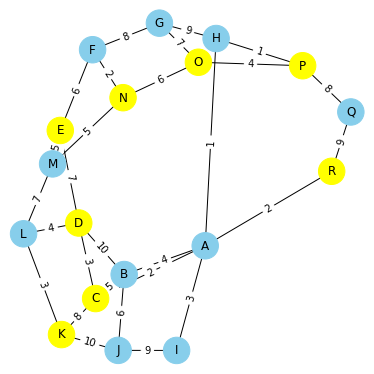

In [19]:
plt.figure(figsize=(5, 5))
nodo_pos = nx.spring_layout(G)  # Layout para posicionar los nodos
nodo_colores = ["yellow" if nodo in nodos_terminales else "skyblue" for nodo in G.nodes]
nx.draw(G, pos=nodo_pos, with_labels=True, node_size=700, node_color=nodo_colores)
nx.draw_networkx_edge_labels(G, pos=nodo_pos, edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.plot()

In [20]:
def subgrafo(grafo: nx.Graph, sistplan: set):    
    aristas = []
    dictarista_recorrido = dict()
    for i in sistplan:
        distancias, caminos  = nx.single_source_dijkstra(grafo, source=i)
        listarecorridos = []
        for r in caminos:
            origen = caminos[r][0] 
            destino = r
            distancia = distancias[r]
            if(origen!=destino and destino in sistplan):
                a = True           
                for destinatario in sistplan:                    
                    if destinatario!=origen and destinatario!=destino and destinatario in caminos[r]:
                        a = False                
                if(a):                     
                    aristas.append((origen, destino, distancia))
                    listarecorridos.append((origen, destino, caminos[r]))
        dictarista_recorrido[origen] = [tuple(k for k in r[2]) for r in listarecorridos]
    grafores = nx.Graph()
    grafores.add_weighted_edges_from(aristas)
    return grafores, dictarista_recorrido

In [21]:
G2, dict_recorridos = subgrafo(G, nodos_terminales)
print(nx.to_dict_of_lists(G2))

{'P': ['O', 'C', 'R'], 'O': ['P', 'N'], 'C': ['P', 'D', 'K', 'R'], 'R': ['P', 'C'], 'D': ['C', 'E', 'K'], 'K': ['C', 'N', 'D'], 'N': ['O', 'E', 'K'], 'E': ['N', 'D']}


<p>Tras reducir el grafo, lo visualizaremos, y como podrás observar, sólo hemos mantenido los nodos con planeta, y las aristas entre estos son los caminos mínimos:</p>

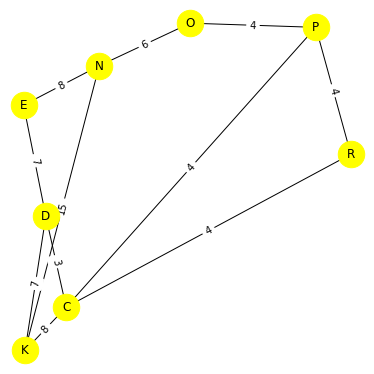

In [22]:
plt.figure(figsize=(5, 5))
nx.draw(G2, pos=nodo_pos, with_labels=True, node_size=700, node_color="yellow")
arista_etiquetas = nx.get_edge_attributes(G2, 'weight')
nx.draw_networkx_edge_labels(G2, pos=nodo_pos, edge_labels=arista_etiquetas)
plt.show()

<p>Podríamos aplicar el algoritmo <strong>tsp</strong> sobre este grafo. Sin embargo, tenemos que hacer otro remapeo para obtener la ruta más eficiente, pues el problema del viajante establece una limitación, que sólo se puede pasar por cada nodo una sola vez.</p>
<p>La forma de solucionar esto es volviendo a crear las aristas, de nuevo con los caminos mínimos.</p>

In [23]:
def remapea(grafo: nx.Graph):
    aristas = []
    dictarista_recorrido = dict()
    for i in grafo.nodes():
        #Distancia desde todos los puntos hasta nuestro punto i
        distancias, caminos  = nx.single_source_dijkstra(grafo, source=i)
        listarecorridos = []
        for r in caminos:
            origen = caminos[r][0] 
            destino = r
            distancia = distancias[r]
            if(origen!=destino):
                aristas.append((origen, destino, distancia))
                listarecorridos.append((origen, destino, caminos[r]))
        dictarista_recorrido[origen] = [tuple(k for k in r[2]) for r in listarecorridos]
    grafores = nx.Graph()
    grafores.add_weighted_edges_from(aristas)
    return grafores, dictarista_recorrido

In [24]:
G3, dict_recorridos2 = remapea(G2)
print(nx.to_dict_of_lists(G3))

{'P': ['O', 'C', 'R', 'N', 'D', 'K', 'E'], 'O': ['P', 'N', 'C', 'R', 'E', 'K', 'D'], 'C': ['P', 'O', 'D', 'K', 'R', 'E', 'N'], 'R': ['P', 'O', 'C', 'D', 'K', 'E', 'N'], 'N': ['P', 'O', 'C', 'R', 'D', 'K', 'E'], 'D': ['P', 'O', 'C', 'R', 'E', 'K', 'N'], 'K': ['P', 'O', 'C', 'R', 'D', 'N', 'E'], 'E': ['P', 'O', 'C', 'R', 'D', 'K', 'N']}


<p>Lo visualizamos:</p>

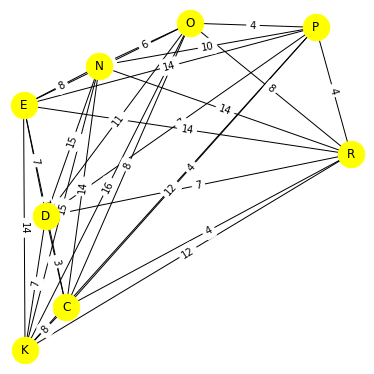

In [25]:
plt.figure(figsize=(5, 5))
nx.draw(G3, pos=nodo_pos, with_labels=True, node_size=700, node_color="yellow")
arista_etiquetas = nx.get_edge_attributes(G3, 'weight')
nx.draw_networkx_edge_labels(G3, pos=nodo_pos, edge_labels=arista_etiquetas)
plt.show()

<p>Ahora sí podemos aplicar el algoritmo <strong>tsp</strong>, se ha de tener en cuenta que como la complejidad de tsp es <strong>n!</strong>, usaremos un método voraz para hallar la solución.</p>
<p>Este algoritmo no es nuestro, sino extraido de la documentación de <em>networkx</em>.</p>

In [26]:
def swap_two_nodes(soln, seed):
    a, b = random.sample(range(1, len(soln) - 1), k=2)
    soln[a], soln[b] = soln[b], soln[a]
    return soln

def pairwise(iterable, cyclic=False):
    "s -> (s0, s1), (s1, s2), (s2, s3), ..."
    a, b = tee(iterable)
    first = next(b, None)
    if cyclic is True:
        return zip(a, chain(b, (first,)))
    return zip(a, b)

def greedy_tsp(G: nx.Graph, weight="weight", source=None):
    # Check that G is a complete graph
    N = len(G) - 1
    # This check ignores selfloops which is what we want here.
    if any(len(nbrdict) - (n in nbrdict) != N for n, nbrdict in G.adj.items()):
        raise nx.NetworkXError("G must be a complete graph.")

    if source is None:
        source = nx.utils.arbitrary_element(G)

    if G.number_of_nodes() == 2:
        neighbor = next(G.neighbors(source))
        return [source, neighbor, source]

    nodeset = set(G)
    nodeset.remove(source)
    cycle = [source]
    next_node = source
    while nodeset:
        nbrdict = G[next_node]
        next_node = min(nodeset, key=lambda n: nbrdict[n].get(weight, 1))
        cycle.append(next_node)
        nodeset.remove(next_node)
    cycle.append(cycle[0])
    return cycle

def tsp(
    G,
    init_cycle="greedy",
    weight="weight",
    source=None,
    temp=500,
    move="1-1",
    max_iterations=10,
    N_inner=1000,
    alpha=0.01,
    seed=None,
):

    if move == "1-1":
        move = swap_two_nodes
    elif move == "1-0":
        move = move_one_node
    if init_cycle == "greedy":
        # Construct an initial solution using a greedy algorithm.
        cycle = greedy_tsp(G, weight=weight, source=source)
        if G.number_of_nodes() == 2:
            return cycle

    else:
        cycle = list(init_cycle)
        if source is None:
            source = cycle[0]
        elif source != cycle[0]:
            raise nx.NetworkXError("source must be first node in init_cycle")
        if cycle[0] != cycle[-1]:
            raise nx.NetworkXError("init_cycle must be a cycle. (return to start)")

        if len(cycle) - 1 != len(G) or len(set(G.nbunch_iter(cycle))) != len(G):
            raise nx.NetworkXError("init_cycle should be a cycle over all nodes in G.")

        # Check that G is a complete graph
        N = len(G) - 1
        # This check ignores selfloops which is what we want here.
        if any(len(nbrdict) - (n in nbrdict) != N for n, nbrdict in G.adj.items()):
            raise nx.NetworkXError("G must be a complete graph.")

        if G.number_of_nodes() == 2:
            neighbor = next(G.neighbors(source))
            return [source, neighbor, source]

    # Find the cost of initial solution
    cost = sum(G[u][v].get(weight, 1) for u, v in pairwise(cycle))

    count = 0
    best_cycle = cycle.copy()
    best_cost = cost
    while count <= max_iterations and temp > 0:
        count += 1
        for i in range(N_inner):
            adj_sol = move(cycle, seed)
            adj_cost = sum(G[u][v].get(weight, 1) for u, v in pairwise(adj_sol))
            delta = adj_cost - cost
            if delta <= 0:
                # Set current solution the adjacent solution.
                cycle = adj_sol
                cost = adj_cost

                if cost < best_cost:
                    count = 0
                    best_cycle = cycle.copy()
                    best_cost = cost
            else:
                # Accept even a worse solution with probability p.
                p = math.exp(-delta / temp)
                if p >= random.random():
                    cycle = adj_sol
                    cost = adj_cost
        temp -= temp * alpha

    return best_cycle

In [27]:
recorrido = tsp(G3)
print(recorrido)

['P', 'R', 'C', 'K', 'D', 'E', 'N', 'O', 'P']


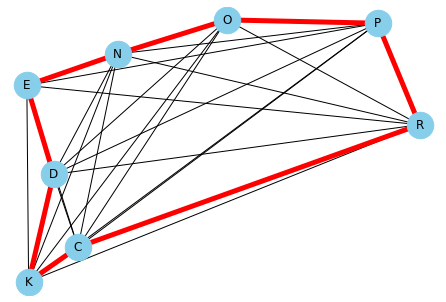

In [28]:
#Camino sobre el grafo reducido
arista_color = {edge: {'color': 'red'} for _, edge in enumerate(zip(recorrido, recorrido[1:]))}
nx.draw(G3, pos=nodo_pos, with_labels=True, node_size=700, node_color='skyblue')
nx.draw_networkx_edges(G3, pos=nodo_pos, edgelist=arista_color.keys(), edge_color='red', width=5)
plt.show()

<p>Una vez que tenemos el recorrido que debemos tomar para la conquista, deberemos reasociar las aristas del subgrafo a los caminos a los que corresponden con el grafo original:</p>

In [29]:
def asocia(lista: list,dicc: dict):
    recorrido = []
    for i in range(len(lista)-1):
        for j in range(len(dicc.get(lista[i]))):
            if lista[i+1]==dicc.get(lista[i])[j][-1]:
                recorrido.extend(dicc.get(lista[i])[j])
    for i in range(len(recorrido)-1, 0, -1):
        if recorrido[i] == recorrido[i-1]:
            del recorrido[i]
    return recorrido

<p>Nuestra ruta será la siguiente representada:</p>

In [30]:
resultado1de2 = asocia(recorrido, dict_recorridos2)
resultado2de2 = asocia(resultado1de2, dict_recorridos)
print(resultado2de2)
peso_total = sum([G.edges()[(resultado2de2[i], resultado2de2[i + 1])]["weight"] for i in range(0, len(resultado2de2)-1)])
print("El peso total de nuestra ruta es de: ", peso_total)

['P', 'H', 'A', 'R', 'A', 'C', 'K', 'L', 'D', 'E', 'F', 'N', 'O', 'P']
El peso total de nuestra ruta es de:  48


<p>Plasmamos el problema a un grafo:</p>

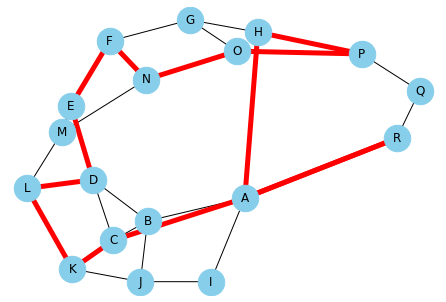

In [31]:
arista_color = {edge: {'color': 'red'} for _, edge in enumerate(zip(resultado2de2, resultado2de2[1:]))}
nx.draw(G, pos=nodo_pos, with_labels=True, node_size=700, node_color='skyblue')
nx.draw_networkx_edges(G, pos=nodo_pos, edgelist=arista_color.keys(), edge_color='red', width=5)
plt.show()